<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: Mariya Mansurova, Analyst & developer in Yandex.Metrics team. Translated by Ivan Zakharov, ML enthusiast. <br>This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis) + [solution](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis-solution).**

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

4.1.1


## Data preparation

In [4]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [5]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [6]:
df.date = pd.to_datetime(df.date)

In [7]:
plotly_df(df.set_index('date')[['count']])

In [ ]:
from fbprophet import Prophet

In [10]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- **3426**
- 5229
- 2744

In [13]:
train_df = df[:-predictions].copy()

In [ ]:
m = Prophet()
m.fit(train_df)

In [ ]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

In [ ]:
m.plot(forecast)

Estimate the quality of the prediction with the last 30 points.

**<font color='red'>Question 2:</font> What is MAPE equal to?**

- __34.5__
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- __600__
- 903

In [ ]:
m.plot_components(forecast)

In [ ]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [ ]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 2))

## Predicting with ARIMA

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- **Series is not stationary, p_value = 0.107**
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

Dickey-Fuller test: p=0.107392


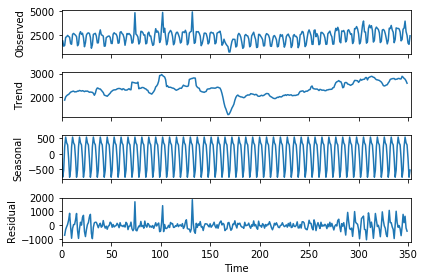

In [15]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [16]:
train_df.set_index('ds', inplace=True)

Dickey-Fuller test: p=0.000000


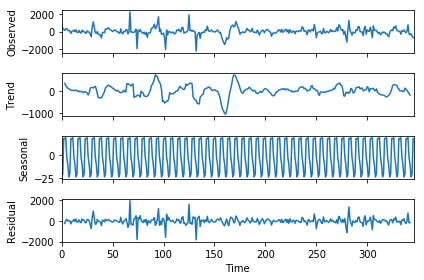

In [17]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

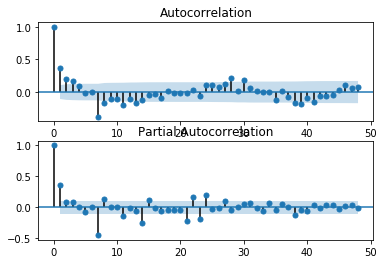

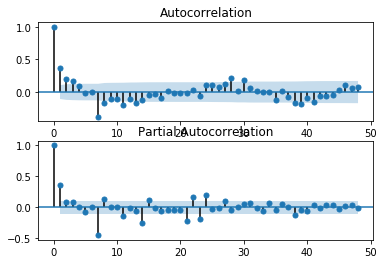

In [18]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [19]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [20]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [21]:
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|████████████████████████████████████████| 384/384 [15:06<00:00,  2.36s/it]


In [22]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
136  (0, 1, 2, 3, 2, 1)  4961.632629
268  (1, 1, 1, 3, 2, 1)  4962.829055
157  (0, 1, 3, 3, 2, 1)  4969.534605
178  (1, 0, 0, 3, 2, 1)  4973.212241
76   (0, 0, 3, 3, 2, 1)  4978.036900


In [23]:
result_table1[result_table1['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,parameters,aic
211,"(1, 0, 2, 3, 1, 0)",5022.312524
280,"(1, 1, 2, 3, 1, 1)",5019.555903
282,"(1, 1, 2, 3, 2, 1)",4988.967973


In [24]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [25]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|████████████████████████████████████████| 384/384 [10:02<00:00,  1.57s/it]


In [26]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
223  (1, 0, 2, 3, 2, 1)  3528.652931
181  (1, 0, 0, 3, 2, 1)  3530.524249
202  (1, 0, 1, 3, 2, 1)  3532.092279
277  (1, 1, 1, 3, 2, 1)  3534.434782
292  (1, 1, 2, 3, 2, 1)  3534.540192


In [27]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by='aic')

,parameters,aic
292,"(1, 1, 2, 3, 2, 1)",3534.540192
220,"(1, 0, 2, 3, 1, 0)",3556.880030
290,"(1, 1, 2, 3, 1, 1)",3557.853668


**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- **D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1**
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [28]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -1756.326
Date:                           Mon, 23 Sep 2019   AIC                           3528.653
Time:                                   20:58:37   BIC                           3559.261
Sample:                                        0   HQIC                          3540.850
                                           - 353                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8204      0.117      7.038      0.000       0.592       1.049
ma.L1         -0.3357      0.123     -2.732